In [2]:
conda install pytorch torchvision torchaudio -c pytorch

Jupyter detected...
2 channel Terms of Service accepted
Channels:
 - pytorch
 - defaults
Platform: osx-arm64
doneng package metadata (repodata.json): 
doneing environment: | 


==> WARNING: A newer version of conda exists. <==
    current version: 25.5.1
    latest version: 25.11.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
print(torch.__version__)
print(torch.rand(2, 3))

2.5.1
tensor([[0.5475, 0.5446, 0.1139],
        [0.0985, 0.2035, 0.9983]])


In [4]:
import tarfile
from pathlib import Path

data_root = Path('./data')
tar_path = data_root / 'cifar-10-python.tar'  # 和你截图里的名字一致

print("Tar file exists:", tar_path.exists(), tar_path)

if tar_path.exists():
    with tarfile.open(tar_path, 'r:') as tar:
        tar.extractall(path=data_root)
    print("Extracted to:", data_root)
else:
    print("Tar file not found, please check the file name/path.")

Tar file exists: True data/cifar-10-python.tar
Extracted to: data


In [5]:
import os
print(os.listdir('data'))

['cifar-10-python.tar', 'cifar-10-batches-py']


In [6]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

data_root = './data'   # 这一层下面现在有 cifar-10-batches-py 目录

train_data = datasets.CIFAR10(root=data_root, train=True,
                              download=False, transform=transform)

test_data  = datasets.CIFAR10(root=data_root, train=False,
                              download=False, transform=transform)

In [7]:
from torchvision import datasets, transforms

test_data = datasets.CIFAR10(root='./data', train=False,
                             download=False, transform=transforms.ToTensor())

print("Test size:", len(test_data))
print("One image shape:", test_data[0][0].shape, "label:", test_data[0][1])

Test size: 10000
One image shape: torch.Size([3, 32, 32]) label: 3


In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

# ========= 环境信息 =========
print("Python version:", os.sys.version)
print("PyTorch version:", torch.__version__)
train_on_gpu = torch.cuda.is_available()
print("CUDA available:", train_on_gpu)
device = torch.device("cuda" if train_on_gpu else "cpu")

# ========= 超参数 =========
num_workers = 2       # DataLoader 的工作进程
batch_size  = 64
valid_size  = 0.2     # 训练集划 20% 做验证集

# ========= 数据增强 & 归一化 =========
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# ========= 加载 CIFAR‑10（只从本地读，不再联网） =========
data_root = './data'

train_data = datasets.CIFAR10(root=data_root, train=True,
                              download=False, transform=transform_train)

test_data  = datasets.CIFAR10(root=data_root, train=False,
                              download=False, transform=transform_test)

# ========= 划分训练 / 验证 =========
num_train = len(train_data)
indices   = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
valid_idx, train_idx = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler=train_sampler,
                                           num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler=valid_sampler,
                                           num_workers=num_workers)

test_loader  = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=num_workers)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print("Train batches:", len(train_loader),
      " Valid batches:", len(valid_loader),
      " Test batches:", len(test_loader))

Python version: 3.10.19 (main, Oct 21 2025, 16:37:10) [Clang 20.1.8 ]
PyTorch version: 2.5.1
CUDA available: False
Train batches: 625  Valid batches: 157  Test batches: 157


In [9]:
class Net(nn.Module):
    def __init__(self, num_classes: int = 10):
        super(Net, self).__init__()

        # Block1: 3x32x32 -> 32x16x16
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)          # 32x16x16
        )

        # Block2: 32x16x16 -> 64x8x8
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)          # 64x8x8
        )

        # Block3: 64x8x8 -> 128x4x4
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)          # 128x4x4
        )

        self.global_pool = nn.AdaptiveAvgPool2d((2, 2))  # 128x2x2
        flat_dim = 128 * 2 * 2                           # 512

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(flat_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


model = Net(num_classes=10).to(device)
print(model)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (con

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(),
                      lr=0.01,
                      momentum=0.9,
                      weight_decay=5e-4)

In [11]:
import copy
import time

n_epochs = 30            
best_valid_loss = np.inf
best_state_dict = None

for epoch in range(1, n_epochs + 1):
    start = time.time()

    # ---------- train ----------
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += torch.sum(preds == labels).item()
        running_total += labels.size(0)

    train_loss = running_loss / running_total
    train_acc  = running_correct / running_total

    # ---------- validate ----------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels).item()
            val_total += labels.size(0)

    val_loss = val_loss / val_total
    val_acc  = val_correct / val_total

    # Save best model
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        best_state_dict = copy.deepcopy(model.state_dict())
        torch.save(best_state_dict, 'best_cifar10_cnn.pt')

    end = time.time()
    print(f"Epoch [{epoch:02d}/{n_epochs}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc*100:5.2f}% | "
          f"Valid Loss: {val_loss:.4f} Acc: {val_acc*100:5.2f}% | "
          f"Time: {end-start:.1f}s")

print("Best validation loss:", best_valid_loss)

Epoch [01/30] Train Loss: 1.6695 Acc: 37.57% | Valid Loss: 1.4162 Acc: 48.47% | Time: 111.3s
Epoch [02/30] Train Loss: 1.2942 Acc: 53.07% | Valid Loss: 1.4460 Acc: 51.33% | Time: 114.2s
Epoch [03/30] Train Loss: 1.1177 Acc: 59.86% | Valid Loss: 1.0083 Acc: 63.69% | Time: 115.6s
Epoch [04/30] Train Loss: 1.0074 Acc: 64.27% | Valid Loss: 0.8683 Acc: 69.28% | Time: 121.9s
Epoch [05/30] Train Loss: 0.9202 Acc: 67.66% | Valid Loss: 0.8563 Acc: 70.01% | Time: 134.0s
Epoch [06/30] Train Loss: 0.8626 Acc: 69.51% | Valid Loss: 0.7486 Acc: 73.54% | Time: 155.8s
Epoch [07/30] Train Loss: 0.8057 Acc: 71.97% | Valid Loss: 0.7390 Acc: 74.37% | Time: 133.6s
Epoch [08/30] Train Loss: 0.7594 Acc: 73.94% | Valid Loss: 0.7892 Acc: 73.81% | Time: 117.8s
Epoch [09/30] Train Loss: 0.7179 Acc: 75.55% | Valid Loss: 0.6259 Acc: 78.56% | Time: 132.1s
Epoch [10/30] Train Loss: 0.6805 Acc: 76.84% | Valid Loss: 0.6135 Acc: 79.12% | Time: 138.4s
Epoch [11/30] Train Loss: 0.6524 Acc: 77.77% | Valid Loss: 0.6568 Acc:

In [12]:
# 载入最佳模型
model.load_state_dict(torch.load('best_cifar10_cnn.pt', map_location=device))
model.to(device)
model.eval()

test_loss = 0.0
correct_total = 0
total = 0

n_classes = len(classes)
class_correct = np.zeros(n_classes, dtype=np.int64)
class_total   = np.zeros(n_classes, dtype=np.int64)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)

        correct_total += torch.sum(preds == labels).item()
        total += labels.size(0)

        for i in range(labels.size(0)):
            label = labels[i].item()
            class_correct[label] += int(preds[i] == label)
            class_total[label]   += 1

test_loss = test_loss / total
test_acc  = correct_total / total

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc*100:.2f}%")

for i, cls in enumerate(classes):
    if class_total[i] > 0:
        acc_i = 100.0 * class_correct[i] / class_total[i]
        print(f"Class {cls:10s}: {acc_i:5.2f}% ({class_correct[i]}/{class_total[i]})")
    else:
        print(f"Class {cls:10s}: N/A (no samples)")

/var/folders/3q/wm2t5f8n1xx7g31jnsfbvt840000gn/T/ipykernel_47600/1780405973.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cifar1

Test Loss: 0.4424 | Test Accuracy: 84.63%
Class airplane  : 82.60% (826/1000)
Class automobile: 95.80% (958/1000)
Class bird      : 77.30% (773/1000)
Class cat       : 64.00% (640/1000)
Class deer      : 89.20% (892/1000)
Class dog       : 84.00% (840/1000)
Class frog      : 89.20% (892/1000)
Class horse     : 84.90% (849/1000)
Class ship      : 89.70% (897/1000)
Class truck     : 89.60% (896/1000)


In [17]:
conda install matplotlib

Jupyter detected...
2 channel Terms of Service accepted
Channels:
 - defaults
Platform: osx-arm64
doneecting package metadata (repodata.json): - 
doneing environment: - 


==> WARNING: A newer version of conda exists. <==
    current version: 25.5.1
    latest version: 25.11.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/anaconda3/envs/int305

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    contourpy-1.3.1            |  py310h48ca7d4_0         249 KB
    fonttools-4.60.1           |  py310h254cc4a_0         3.6 MB
    kiwisolver-1.4.9           |  py310haeee614_0          60 KB
    matplotlib-3.10.6          |  py310hca03da5_1           7 KB
    matplotlib-base-3.10.6     |  py310h37b8ce2_1         7.2 MB
    packaging-25.0             |  py310hca03da5_1       

Inference example:
 True label: cat
 Pred label: cat
 Confidence: 98.77%


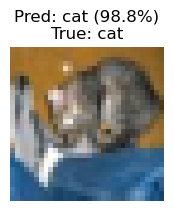

In [18]:
import matplotlib.pyplot as plt

# 从“未归一化版本”的测试集取一张图以便展示原图
# 为了可视化更清楚，这里重新构建一个只做 ToTensor() 的数据集
raw_test_data = datasets.CIFAR10(root=data_root, train=False,
                                 download=False,
                                 transform=transforms.ToTensor())

idx = 0
img_raw, true_label = raw_test_data[idx]   # 只 ToTensor，没有 Normalize

# 与训练时相同的预处理：再做一次 Normalize
input_tensor = transforms.Normalize((0.5, 0.5, 0.5),
                                    (0.5, 0.5, 0.5))(img_raw)
input_tensor = input_tensor.unsqueeze(0).to(device)  # [1, 3, 32, 32]

# 前向推理
model.eval()
with torch.no_grad():
    outputs = model(input_tensor)          
    prob = F.softmax(outputs, dim=1)       
    conf, pred = torch.max(prob, 1)

pred_cls = classes[pred.item()]
true_cls = classes[true_label]
conf_val = conf.item()

print("Inference example:")
print(" True label:", true_cls)
print(" Pred label:", pred_cls)
print(" Confidence:", f"{conf_val*100:.2f}%")

# 显示原图 + 结果
def imshow(img_tensor):
    img = img_tensor.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.axis('off')

plt.figure(figsize=(2, 2))
imshow(img_raw)
plt.title(f"Pred: {pred_cls} ({conf_val*100:.1f}%)\nTrue: {true_cls}")
plt.show()

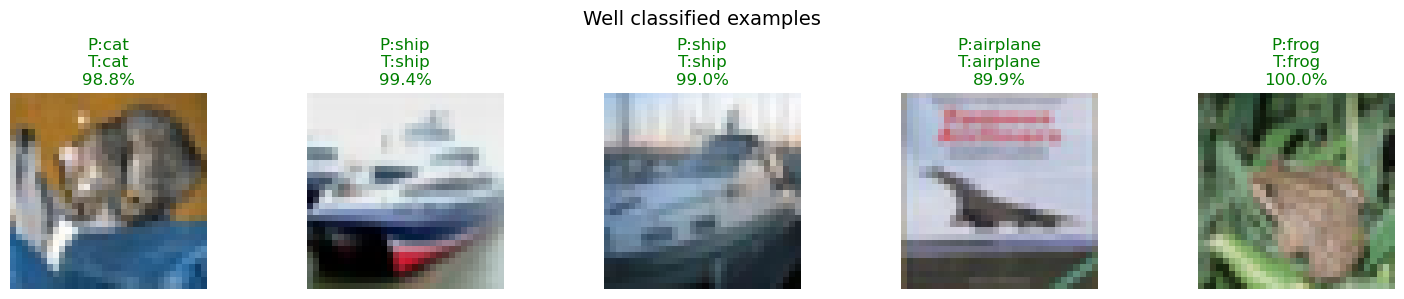

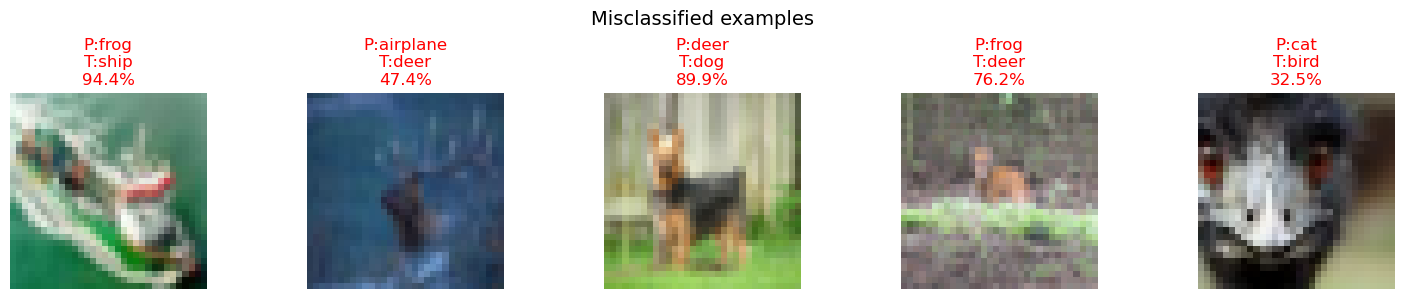

In [19]:
def denorm(img_tensor):
    """反归一化到 [0,1] 方便显示（对应 mean=0.5,std=0.5）"""
    img = img_tensor.clone().cpu()
    img = img * 0.5 + 0.5
    return img

correct_samples = []
wrong_samples = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        confs, preds = torch.max(probs, 1)

        for i in range(images.size(0)):
            img = denorm(images[i])
            true_l = labels[i].item()
            pred_l = preds[i].item()
            conf   = confs[i].item()

            sample = (img, true_l, pred_l, conf)

            if true_l == pred_l and len(correct_samples) < 5:
                correct_samples.append(sample)
            elif true_l != pred_l and len(wrong_samples) < 5:
                wrong_samples.append(sample)

        if len(correct_samples) >= 5 and len(wrong_samples) >= 5:
            break

# ---- Figure: 5 correctly classified examples ----
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Well classified examples", fontsize=14)
for ax, (img, true_l, pred_l, conf) in zip(axes, correct_samples):
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    ax.axis('off')
    ax.set_title(f"P:{classes[pred_l]}\nT:{classes[true_l]}\n{conf*100:.1f}%",
                 color="green")
plt.tight_layout()
plt.show()

# ---- Figure: 5 misclassified examples ----
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Misclassified examples", fontsize=14)
for ax, (img, true_l, pred_l, conf) in zip(axes, wrong_samples):
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    ax.axis('off')
    ax.set_title(f"P:{classes[pred_l]}\nT:{classes[true_l]}\n{conf*100:.1f}%",
                 color="red")
plt.tight_layout()
plt.show()